In [1]:
from ocean_navigation_simulator.utils.misc import get_c3
import os
%load_ext autoreload
%autoreload 2

In [2]:
c3 = get_c3()

Starting to connect to c3


# Set up the experiments

In [3]:
# Configs for Experiment
arena_config = {
    'casadi_cache_dict': {
        'deg_around_x_t': 0.5,
        'time_around_x_t': 86400.0}, # This is 24h in seconds!
 'platform_dict': {'battery_cap_in_wh': 400.0,
                   'u_max_in_mps': 0.2,
                   'motor_efficiency': 1.0,
                   'solar_panel_size': 1.0,
                   'solar_efficiency': 0.2,
                   'drag_factor': 675.0,
                   'dt_in_s': 600.0},
 'use_geographic_coordinate_system': True,
 'spatial_boundary': None,
 'ocean_dict': {
     'area': 'GOM',
     'hindcast': {
         'field': 'OceanCurrents',
         'source': 'hindcast_files',
         'source_settings': {
             'source': 'HYCOM',
             'type': 'hindcast',
             'folder': 'temp/hindcast/'}},
     'forecast': None},
 'solar_dict': {'hindcast': None, 'forecast': None},
 'seaweed_dict': {'hindcast': None, 'forecast': None}}

objectiveConfig = {'type': "nav"}


In [4]:
import datetime
missGenBatchConfig = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    #"x_range": [-97.9, -76.5],
    #"y_range": [18.2, 29.9],
    "x_range": [-97, -78],
    "y_range": [20,30],
    "t_range": [
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=4, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=11, day=1, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": 60,
    "target_distance_from_land": 0.4,
    "problem_target_radius": 0.1,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 6, # Jerome has 6 days here
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 4,
    "random_missions_per_target": 0,
    "min_distance_from_hj_frame": 0.,
    "min_distance_from_land": 0.5,
    "feasible_mission_time_in_h": [30, 50], #Jerome has starting from 20 (so more short-term Mission)
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}

In [7]:
import datetime
import logging
import math
import os
import shutil
import time
import traceback
import warnings
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np

from ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner import (
    HJReach2DPlanner,
)
from ocean_navigation_simulator.data_sources.DataSource import (
    SubsettingDataSourceException,
)
from ocean_navigation_simulator.environment.Arena import ArenaObservation
from ocean_navigation_simulator.environment.ArenaFactory import (
    ArenaFactory,
    CorruptedOceanFileException,
    MissingOceanFileException,
)
from ocean_navigation_simulator.environment.NavigationProblem import (
    NavigationProblem,
)
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    PlatformStateSet,
    SpatioTemporalPoint,
)
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.utils import cluster_utils, units
from ocean_navigation_simulator.utils.misc import bcolors, timing_dict
from ocean_navigation_simulator.utils.units import Distance

logger = logging.getLogger("MissionGenerator")


class MissionGenerator:
    """
    A flexible class to generate missions.
    Each MissionGenerator will try&error until feasible targets/starts are found
     - if parallelized each MissionGenerator should be feed with a different seed and cache_folder for plots
     - problem is uniquely identified by seed/factory index
    """

    def __init__(self, config: Optional[dict] = {}, c3=None):
        # update the config to be in proper units
        if type(config["t_range"][0]) == str:
            config["t_range"] = [datetime.datetime.fromisoformat(t) for t in config["t_range"]]
        self.config = config
        self.c3 = c3

        self.random = np.random.default_rng(self.config["seed"])

    def cache_batch(self) -> Tuple[List[CachedNavigationProblem], dict, List]:
        """Generate Batch, Cache Hindcast, Cache Forecast and Plot Batch"""
        self.performance = {
            "total_time": 0,
            "generate_time": 0,
            "plot_time": 0,
            "forecast_time": 0,
            "hindcast_time": 0,
            "starts": 0,
            "errors": 0,
            "target_resampling": 0,
            "start_resampling": 0,
        }
        self.errors = []

        with timing_dict(
            self.performance,
            "total_time",
            "Batch finished ({})",
            logger,
        ):
            while True:
                try:
                    if self.config["cache_folder"].endswith("/"):
                        os.makedirs(self.config["cache_folder"], exist_ok=True)

                    # Step 1: Generate Batch
                    with timing_dict(
                        self.performance,
                        "generate_time",
                        "Generated Batch ({})",
                        logger,
                    ):
                        problems = self.generate_batch()

                    # Step 2: Plot or Animate Batch
                    if self.config["animate_batch"]:
                        with timing_dict(
                            self.performance,
                            "plot_time",
                            "Animated Batch ({})",
                            logger,
                        ):
                            if self.config["cache_folder"].startswith("/seaweed-storage/"):
                                cluster_utils.ensure_storage_connection()
                            self.plot_last_batch_animation(
                                filename=f"{self.config['cache_folder']}animation.gif"
                            )

                    if self.config["plot_batch"]:
                        with timing_dict(
                            self.performance,
                            "plot_time",
                            "Plotted Batch ({})",
                            logger,
                        ):
                            if self.config["cache_folder"].startswith("/seaweed-storage/"):
                                cluster_utils.ensure_storage_connection()
                            self.plot_last_batch_snapshot(
                                filename=f"{self.config['cache_folder']}snapshot.png"
                            )

                    # step 3: Cache Hindcast Planner
                    if self.config["cache_hindcast"]:
                        with timing_dict(
                            self.performance,
                            "hindcast_time",
                            "Cached Hindcast ({})",
                            logger,
                        ):
                            if self.config["cache_folder"].startswith("/seaweed-storage/"):
                                cluster_utils.ensure_storage_connection()
                            self.hindcast_planner.save_planner_state(
                                f"{self.config['cache_folder']}hindcast_planner/"
                            )

                    # # Step 4: Cache Forecast Planner
                    if self.config["cache_forecast"]:
                        with timing_dict(
                            self.performance,
                            "forecast_time",
                            "Cached Forecast ({})",
                            logger,
                        ):
                            self.run_forecast(problem=problems[0])
                except Exception as e:
                    if hasattr(self, "problems") and len(self.problems):
                        logger.warning(bcolors.red(self.problems[0]))
                    logger.warning(bcolors.red(str(e)))
                    logger.warning(traceback.format_exc())
                    self.performance["errors"] += 1
                    self.errors.append(str(e))
                    shutil.rmtree(self.config["cache_folder"], ignore_errors=True)
                else:
                    break

        self.performance["starts"] = len(self.problems)

        return self.problems, self.performance, self.errors

    def generate_batch(self) -> List[CachedNavigationProblem]:
        """Generate a target and a batch of starts according to config"""
        self.problems = []

        # Step 1: Generate Target & Starts until enough valid target/starts found
        while not (target := self.generate_target()) or not (starts := self.generate_starts()):
            pass

        # Step 2: Create Problems
        for random, start, distance_to_shore in starts:
            ttr = self.hindcast_planner.interpolate_value_function_in_hours(point=start).item()
            feasible = ttr < self.config["problem_timeout_in_h"]

            self.problems.append(
                CachedNavigationProblem(
                    start_state=PlatformState(
                        lon=start.lon,
                        lat=start.lat,
                        date_time=start.date_time,
                    ),
                    end_region=target.to_spatial_point(),
                    target_radius=self.config["problem_target_radius"],
                    platform_dict=self.arena.platform.platform_dict,
                    extra_info={
                        "timeout_datetime": target.date_time.isoformat(),
                        "start_target_distance_deg": target.haversine(start).deg,
                        "feasible": feasible,
                        "ttr_in_h": ttr,
                        "random": random,
                        "distance_to_shore_deg": distance_to_shore.deg,
                        # Planner Caching
                        "x_cache": self.hj_planner_frame["x_interval"],
                        "y_cache": self.hj_planner_frame["y_interval"],
                        # "t_cache": self.hj_planner_time_frame,
                        # Factory
                        "factory_seed": self.config["seed"],
                        "factory_index": len(self.problems),
                    },
                )
            )
            logger.debug(f"Problem created: {self.problems[-1]}")

        return self.problems

    def generate_target(self) -> Union[SpatioTemporalPoint, bool]:
        """
        Samples a target in x_range/y_range/t_range.
        - ensures that all required files available on c3
        - ensures distance to shore
        - runs hj planner for target
        Returns:
            SpatioTemporalPoint to be a target
        """
        start_time = time.time()

        ##### Step 1: Generate Target (x,y,t_T) #####
        # Planner starts from timeout backwards (this is a trick, so we can use the planner after max_mission_range)!
        fake_target = SpatioTemporalPoint(
            lon=units.Distance(
                deg=self.random.uniform(self.config["x_range"][0], self.config["x_range"][1])
            ),
            lat=units.Distance(
                deg=self.random.uniform(self.config["y_range"][0], self.config["y_range"][1])
            ),
            # only sample goal times s.t. all missions will start and timeout in t_interval
            date_time=datetime.datetime.fromtimestamp(
                self.random.uniform(
                    (
                        self.config["t_range"][0]
                        + datetime.timedelta(hours=self.config["problem_timeout_in_h"])
                    ).timestamp(),
                    self.config["t_range"][1].timestamp(),
                ),
                tz=datetime.timezone.utc,
            ),
        )
        fake_start = PlatformState(
            lon=fake_target.lon,
            lat=fake_target.lat,
            date_time=fake_target.date_time
            - datetime.timedelta(hours=self.config["problem_timeout_in_h"]),
        )

        ##### Step 2: Reject if files are missing or corrupted #####
        try:
            self.arena = ArenaFactory.create(
                scenario_file=self.config.get("scenario_file", None),
                scenario_config=self.config.get("scenario_config", None),
                x_interval=[units.Distance(deg=x) for x in self.config["x_range"]],
                y_interval=[units.Distance(deg=y) for y in self.config["y_range"]],
                t_interval=[
                    fake_start.date_time - datetime.timedelta(hours=1),
                    fake_target.date_time + datetime.timedelta(days=1, hours=1),
                ],
                throw_exceptions=True,
                c3=self.c3,
            )
            self.arena.reset(platform_set=PlatformStateSet(platform_list=[fake_start]))
        except (MissingOceanFileException, CorruptedOceanFileException) as e:
            logger.warning(
                f"Target aborted because of missing or corrupted files: [{fake_start.date_time}, {fake_target.date_time}]."
            )
            logger.warning(e)
            self.performance["errors"] += 1
            self.errors.append(str(e))
            return False

        # Step 3: Reject if to close to land
        distance_to_shore = self.arena.ocean_field.hindcast_data_source.distance_to_land(
            fake_target.to_spatial_point()
        )
        if distance_to_shore.deg < self.config["target_distance_from_land"]:
            logger.warning(
                f"Target aborted because too close to land: {fake_target.to_spatial_point()} = {distance_to_shore}."
            )
            self.performance["target_resampling"] += 1
            return False

        ##### Step 3: Run multi-time-back HJ Planner #####
        try:
            self.hj_planner_frame = {
                "x_interval": [
                    fake_target.lon.deg - self.config["hj_planner_box"],
                    fake_target.lon.deg + self.config["hj_planner_box"],
                ],
                "y_interval": [
                    fake_target.lat.deg - self.config["hj_planner_box"],
                    fake_target.lat.deg + self.config["hj_planner_box"],
                ],
            }
            with timing_dict(
                self.performance,
                "hindcast_time",
                "Run Hindcast Planner ({})",
                logger,
                logging.INFO,
            ):
                self.hindcast_planner = HJReach2DPlanner(
                    problem=NavigationProblem(
                        start_state=fake_start,
                        end_region=fake_target.to_spatial_point(),
                        target_radius=self.config["problem_target_radius"],
                        platform_dict=self.arena.platform.platform_dict,
                    ),
                    specific_settings=self.config["hj_specific_settings"] | self.hj_planner_frame,
                )
                self.hindcast_planner.replan_if_necessary(
                    ArenaObservation(
                        platform_state=fake_start,
                        true_current_at_state=self.arena.ocean_field.get_ground_truth(
                            fake_start.to_spatio_temporal_point()
                        ),
                        forecast_data_source=self.arena.ocean_field.hindcast_data_source,
                    )
                )
                self.hindcast_planner.plot_reachability_snapshot(
                    rel_time_in_seconds=0,
                    granularity_in_h=5,
                    alpha_color=1,
                    time_to_reach=True,
                    fig_size_inches=(12, 12),
                    plot_in_h=True,
                    return_ax=False,
                )
                self.hindcast_planner.plot_reachability_snapshot_over_currents()
                # self.hindcast_planner.plot_reachability_animation(time_to_reach=True, filename="reach_anim.gif")
                self.arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
                    time=fake_start.date_time,
                    x_interval=self.hj_planner_frame["x_interval"],
                    y_interval=self.hj_planner_frame["y_interval"],
                    colorbar=True,
                )
        except SubsettingDataSourceException as e:
            logger.warning(
                "Target aborted because of subsetting exception: [{fake_start.date_time}, {fake_target.date_time}]."
            )
            logger.warning(e)
            self.performance["errors"] += 1
            self.errors.append(str(e))
            return False

        ##### Overwrite with biggest available time in hj planner #####
        real_target = SpatioTemporalPoint(
            lon=fake_start.lon,
            lat=fake_start.lat,
            # Largest available time in hj planner
            date_time=datetime.datetime.fromtimestamp(
                math.floor(
                    self.hindcast_planner.current_data_t_0 + self.hindcast_planner.reach_times[-1]
                ),
                tz=datetime.timezone.utc,
            ),
        )

        logger.info(f"Target created: {real_target} ({time.time()-start_time:.1f}s).")

        return real_target

    def generate_starts(self) -> Union[List[Tuple[bool, SpatioTemporalPoint, float]], bool]:
        """
        Samples in/feasible starts from the already generated target.
        Returns:
            List of starts for the pre-existing target.
        """
        start_time = time.time()

        sampling_frame = {
            "x": [
                self.hj_planner_frame["x_interval"][0] + self.config["min_distance_from_hj_frame"],
                self.hj_planner_frame["x_interval"][1] - self.config["min_distance_from_hj_frame"],
            ],
            "y": [
                self.hj_planner_frame["y_interval"][0] + self.config["min_distance_from_hj_frame"],
                self.hj_planner_frame["y_interval"][1] - self.config["min_distance_from_hj_frame"],
            ],
        }
        mission_time = [
            int(self.config["feasible_mission_time_in_h"][0] * 3600),
            int(self.config["feasible_mission_time_in_h"][1] * 3600),
        ]
        feasible_points = self.sample_feasible_points(sampling_frame, mission_time)
        random_points = self.sample_random_points(sampling_frame)

        if len(feasible_points) < self.config["feasible_missions_per_target"]:
            logger.warning(
                f"Only {len(feasible_points)}/{self.config['feasible_missions_per_target']} feasible points available."
            )
        elif len(random_points) < self.config["random_missions_per_target"]:
            logger.warning(
                f"Only {len(random_points)}/{self.config['random_missions_per_target']} random points available."
            )
        else:
            logger.info(
                f"{len(feasible_points + random_points)} starts created ({time.time()-start_time:.1f}s)."
            )

        return feasible_points + random_points

    def sample_feasible_points(
        self, sampling_frame, mission_time
    ) -> List[Tuple[bool, SpatioTemporalPoint, Distance]]:
        planner = self.hindcast_planner

        # Step 1: Find reachable points with minimum distance from frame
        reach_times = (planner.all_values[0] - planner.all_values.min()) * (
            planner.current_data_t_T - planner.current_data_t_0
        )
        reachable_condition = (mission_time[0] < reach_times) & (reach_times < mission_time[1])
        frame_condition_x = (sampling_frame["x"][0] < planner.grid.states[:, :, 0]) & (
            planner.grid.states[:, :, 0] < sampling_frame["x"][1]
        )
        frame_condition_y = (sampling_frame["y"][0] < planner.grid.states[:, :, 1]) & (
            planner.grid.states[:, :, 1] < sampling_frame["y"][1]
        )
        points_to_sample = np.argwhere(reachable_condition & frame_condition_x & frame_condition_y)

        logger.info(
            "Sampling Ratio: {n}/{d} = {ratio:.2%}".format(
                n=points_to_sample.shape[0],
                d=planner.all_values[0].size,
                ratio=points_to_sample.shape[0] / planner.all_values[0].size,
            )
        )

        # Step 2: Return List of SpatioTemporalPoint
        sampled_points = []
        for _ in range(
            min(5 * self.config["feasible_missions_per_target"], points_to_sample.shape[0])
        ):
            # Sample Coordinates
            sample_index = self.random.integers(points_to_sample.shape[0])
            sampled_point = points_to_sample[sample_index]
            points_to_sample = np.delete(points_to_sample, sample_index, axis=0)
            coordinates = planner.grid.states[sampled_point[0], sampled_point[1], :]

            # Add Noise
            noise = (
                self.config["hj_specific_settings"]["grid_res"] * self.random.uniform(-0.5, 0.5),
                self.config["hj_specific_settings"]["grid_res"] * self.random.uniform(-0.5, 0.5),
            )

            # Format
            point = SpatioTemporalPoint(
                lon=units.Distance(deg=coordinates[0] + noise[0]),
                lat=units.Distance(deg=coordinates[1] + noise[1]),
                # Smallest available time in hj planner
                date_time=datetime.datetime.fromtimestamp(
                    math.ceil(planner.current_data_t_0 + planner.reach_times[0]),
                    tz=datetime.timezone.utc,
                ),
            )

            # Add if far enough from shore
            distance_to_shore = self.arena.ocean_field.hindcast_data_source.distance_to_land(
                point.to_spatial_point()
            )
            if distance_to_shore.deg > self.config["min_distance_from_land"]:
                sampled_points.append((False, point, distance_to_shore))
            else:
                self.performance["start_resampling"] += 1
            if len(sampled_points) >= self.config["feasible_missions_per_target"]:
                break

        return sampled_points

    def sample_random_points(
        self, sampling_frame
    ) -> List[Tuple[bool, SpatioTemporalPoint, Distance]]:
        """uniform Sampling in Frame"""
        sampled_points = []

        for _ in range(2 * self.config["random_missions_per_target"]):
            point = SpatioTemporalPoint(
                lon=units.Distance(
                    deg=self.random.uniform(sampling_frame["x"][0], sampling_frame["x"][1])
                ),
                lat=units.Distance(
                    deg=self.random.uniform(sampling_frame["y"][0], sampling_frame["y"][1])
                ),
                # Smallest available time in hj planner
                date_time=datetime.datetime.fromtimestamp(
                    math.ceil(
                        self.hindcast_planner.current_data_t_0
                        + self.hindcast_planner.reach_times[0]
                    ),
                    tz=datetime.timezone.utc,
                ),
            )

            # Add if far enough from shore
            distance_to_shore = self.arena.ocean_field.hindcast_data_source.distance_to_land(
                point.to_spatial_point()
            )
            if distance_to_shore.deg > self.config["min_distance_from_land"]:
                sampled_points.append((True, point, distance_to_shore))
            else:
                self.performance["start_resampling"] += 1
            if len(sampled_points) >= self.config["random_missions_per_target"]:
                break

        return sampled_points

    def add_problems_to_ax(self, ax: plt.axis, rel_time_in_seconds=0):
        # Add Starts to Plot
        for problem in self.problems:
            ax.scatter(
                problem.start_state.lon.deg,
                problem.start_state.lat.deg,
                facecolors="black" if problem.extra_info["random"] else "none",
                edgecolors="black" if problem.extra_info["random"] else "r",
                marker="o",
                label="starts",
            )

    def plot_last_batch_snapshot(self, filename: str = None):
        if len(self.problems) == 0:
            raise Exception("plot_last_batch_snapshot can only be called after generate_batch.")

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            ax = self.hindcast_planner.plot_reachability_snapshot_over_currents(return_ax=True)
        self.add_problems_to_ax(ax)

        if filename is None:
            ax.get_figure().show()
        else:
            ax.get_figure().savefig(filename)

    def plot_last_batch_animation(self, filename):
        if len(self.problems) == 0:
            raise Exception("plot_last_batch_animation can only be called after generate_batch.")

        def add_Drawing(*args):
            self.add_problems_to_ax(*args)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            self.hindcast_planner.plot_reachability_animation(
                filename=filename,
                add_drawing=add_Drawing,
            )

    def run_forecast(self, problem):
        """
        We have to trick the planner here to run exactly the forecasts we need:
            - we take any problem of the current batch (they share the same target, so the planner is the same)
            - we run until timeout (problem.is_done == -1)
            - we reset the platform x&y to start coordinates s.t. we never runs out of area
        """
        forecast_planner = HJReach2DPlanner(
            problem=problem,
            specific_settings=self.hindcast_planner.specific_settings
            | self.hj_planner_frame
            | {"planner_path": self.config["cache_folder"], "save_after_planning": True},
        )

        # # Run Arena until Timeout (use start position to not leave arena)
        # sim_date_time = problem.start_state.date_time
        # while sim_date_time < problem.start_state.date_time + problem.timeout:
        #     forecast_planner.replan_if_necessary(
        #         ArenaObservation(
        #             platform_state=PlatformState(
        #                 lon=problem.start_state.lon,
        #                 lat=problem.start_state.lat,
        #                 date_time=sim_date_time,
        #             ),
        #             true_current_at_state=self.arena.ocean_field.get_ground_truth(
        #                 problem.start_state.to_spatio_temporal_point()
        #             ),
        #             forecast_data_source=self.arena.ocean_field.forecast_data_source,
        #         )
        #     )
        #     sim_date_time += datetime.timedelta(minutes=10)

        arena = ArenaFactory.create(
            scenario_file=self.config["scenario_file"],
            problem=problem,
            throw_exceptions=True,
            c3=self.c3,
        )

        # Run Arena until Timeout (reset position to no leave arena)
        observation = arena.reset(problem.start_state)

        while problem.is_done(observation.platform_state) != -1:
            observation = arena.step(forecast_planner.get_action(observation))
            arena.platform.state.lon = problem.start_state.lon
            arena.platform.state.lat = problem.start_state.lat

/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



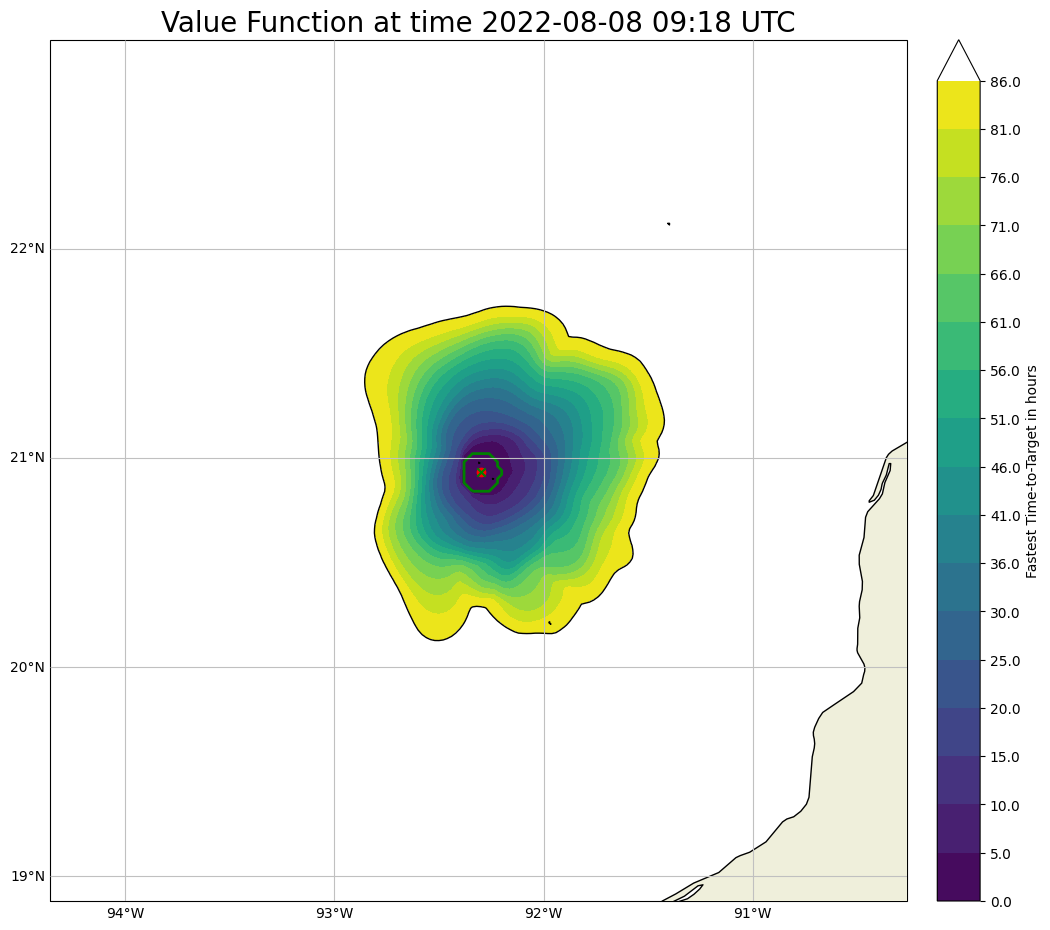

/home/nicolas/miniconda3/envs/ocean_minimal/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning:

No contour levels were found within the data range.



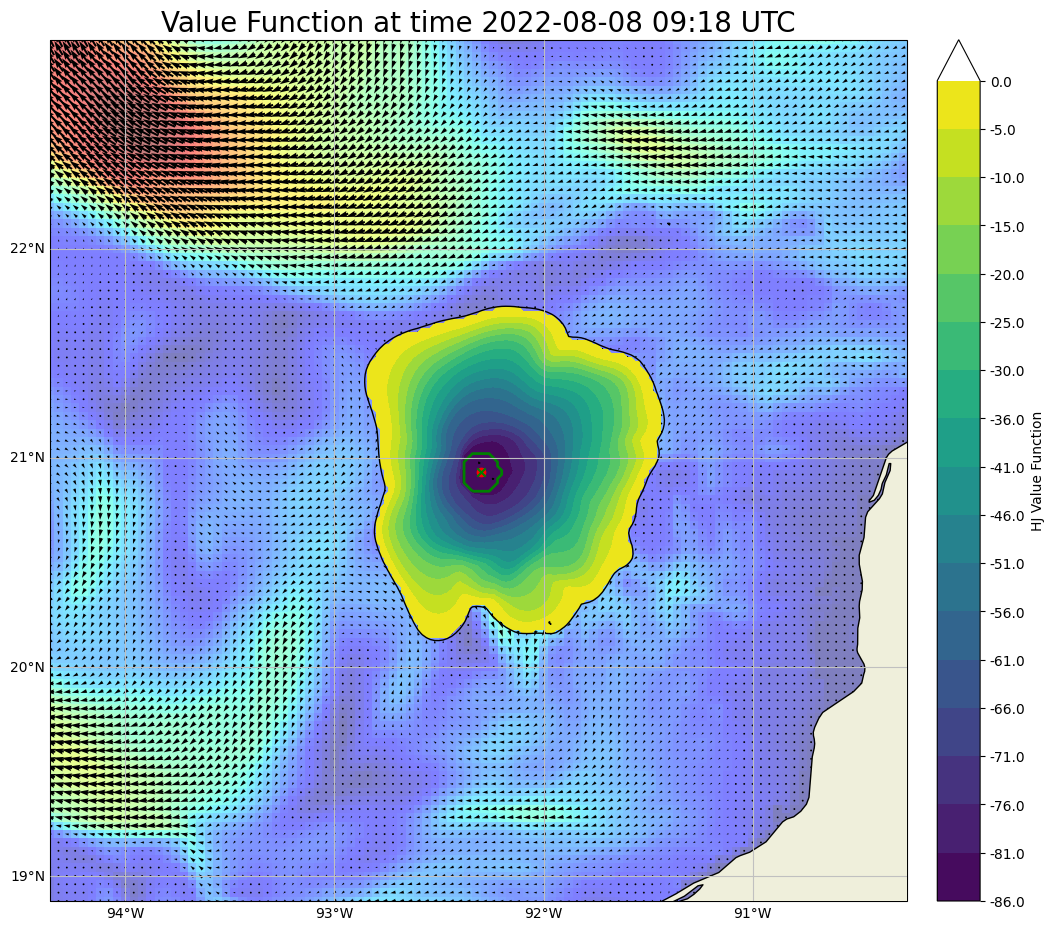

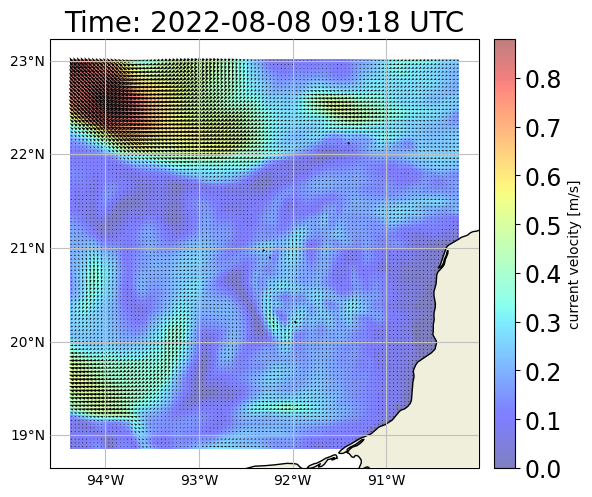

In [8]:
import random
# create the MissionGenerator Config
config = missGenBatchConfig
config_to_add = {
    "scenario_config": arena_config,
    # "problem_timeout": datetime.timedelta(
    #     seconds=exp.get("timeout_in_sec").timeout_in_sec
    # ),
    # "T_goal_in_seconds": exp.get("timeout_in_sec").timeout_in_sec,
}

config = config | config_to_add

results_folder = "/tmp/missions/"
# os.makedirs(results_folder, exist_ok=True)
# seed all of them
all_problems_c3 = []
for worker in range(1):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": 2022,#int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
        c3=c3,
    )
    problems_c3, _, _ = mission_generator.cache_batch()
    all_problems_c3.extend(problems_c3)